In [1]:

#Sandesh
import os
import numpy as np
from PIL import Image

def LoadSceneAndLabel(dirnameScene, dirnameLabel, numImages):
    count = 0
    sceneX = []
    sceneY = []
    for sceneName in os.listdir(dirnameScene):
        scene = Image.open(os.path.join(dirnameScene, sceneName))
        sceneLabel = Image.open(os.path.join(dirnameLabel, sceneName[:-4]+"_drivable_color.png"))
        #scene.show()
        #sceneLabel.show()
        #print(scene.size)
        #print(sceneLabel.size)
        sceneX.append(scene)
        sceneY.append(sceneLabel)
        count += 1
        if count >= numImages:
          break
    return sceneX, sceneY

dataX, dataY = LoadSceneAndLabel(dirnameScene="bdd100k/images/100k/train", dirnameLabel="bdd100k/drivable_maps/color_labels/train", numImages=800)
valX, valY = LoadSceneAndLabel(dirnameScene="bdd100k/images/100k/val", dirnameLabel="bdd100k/drivable_maps/color_labels/val", numImages=50)

dataX[0].size


(1280, 720)

In [2]:
import math

def compress(x, y, rate=0.5):
    global xSize
    global ySize
    print((x[0].size))
    xSize = math.floor(((x[0].size)[0])*rate)
    ySize = math.floor(((y[0].size)[1])*rate)
#     print(xSize)
#     print(ySize)
    sceneX = [img.resize([xSize, ySize]) for img in x]  
    sceneY = [img.resize([xSize, ySize]) for img in y]  
    #sceneX[0].show()
    #sceneY[0].show()
    return sceneX, sceneY

# #print(SceneLabelPair[0][0].size)
dataX, dataY = compress(dataX, dataY, rate=0.1)
# print(SceneLabelPair[0][0].size)
valX, valY = compress(valX, valY, rate=0.1)

print(dataX[0].size)

(1280, 720)
(1280, 720)
(128, 72)


In [3]:
# import torchvision.transforms.functional as TF

# import random

# #list is pass by reference so copy isn't made

# def transformImages(image, mask):

#     for n in range(len(image)):
# #         # Resize
# #         resize = transforms.Resize(size=(520, 520))
# #         image = resize(image)
# #         mask = resize(mask)

# #         # Random crop
# #         i, j, h, w = transforms.RandomCrop.get_params(
# #             image, output_size=(512, 512))
# #         image = TF.crop(image, i, j, h, w)
# #         mask = TF.crop(mask, i, j, h, w)

#         # Random horizontal flipping
#         if random.random() > 0.5:
#             image[n] = TF.hflip(image[n])
#             mask[n] = TF.hflip(mask[n])

#         # Random vertical flipping
#         if random.random() > 0.5:
#             image[n] = TF.vflip(image[n])
#             mask[n] = TF.vflip(mask[n])

# #         # Transform to tensor
# #         image = TF.to_tensor(image)
# #         mask = TF.to_tensor(mask)
# #     return image, mask

    
# #transform dataX and dataY, doesn't return anything since passed by reference
# transformImages(dataX, dataY)

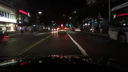

In [4]:
img = 0
dataX[img]

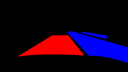

In [5]:
dataY[img]

## maybe flatten y?

In [6]:
# 
#convert non zero label to be the same number so it's not different based on different lane categorization

def convert_to_array(x, y):
    sceneX = []
    sceneY = []
    count = 0
    for img in x:
        #img = img.convert('LA')  # convert to grayscale
        #img = np.squeeze(np.array(img)[:,:,:])
        img = np.array(img)
        #divide by 255.0
        img = np.divide(img, 255.0)
        sceneX.append(img)
    for img in y:
        img = img.convert('LA')  # convert to grayscale
        if count == 0:
            img.show()
        count = 1
        img = np.squeeze(np.array(img)[:,:,0])
        img = np.where(img > 0, 1, 0)
        sceneY.append(img)
#     img = np.squeeze(np.array(img)[:, :, 0]) #squeeze to remove the unnecessary dimension after conversion to grayscale
#     label_img = np.squeeze(np.array(label_img)[:, :, 0])
    return np.array(sceneX), np.array(sceneY)

dataX, dataY = convert_to_array(dataX, dataY)
valX, valY = convert_to_array(valX, valY)

In [7]:
print(len(dataX))
print(len(dataY))


dataX.shape

800
800


(800, 72, 128, 3)

### Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

split = 2/7.0
print(split)

trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=split) 






0.2857142857142857


In [9]:
train_num = trainX.shape[0]
test_num = testX.shape[0]
x_dim = trainX.shape[2]
y_dim = trainX.shape[1]
val_num = valX.shape[0]



# Pytorch CNN Model

Module is the baseclass for all NN module:
https://pytorch.org/docs/stable/generated/torch.nn.Module.html

### Conv2D -> 
Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
https://cs231n.github.io/convolutional-networks/
out_channels = number of kernels (filters) used, so dim in the 3rd dim


### BatchNorm2d ->
BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Batch normalization normalizes the activations of the network between layers in batches so that the batches have a mean of 0 and a variance of 1.
param = num of channels

### nn.Linear ->
Linear(in_features, out_features, bias=True)



### Convert to PyTorch types


In [10]:
import torch
# train

trainX = trainX.reshape(train_num, 3, y_dim, x_dim).astype(float)
print(trainX[0])
print(trainX.shape)
trainX  = torch.from_numpy(trainX).type(torch.FloatTensor)

# trainY = trainY.reshape(train_num, 1, x_dim, y_dim).astype(float)
# trainY  = torch.from_numpy(trainY)
# print(trainY.shape)

trainY = trainY.reshape(train_num, 1, y_dim, x_dim).astype(float)
#trainY  = torch.from_numpy(trainY).type(torch.LongTensor)
trainY  = torch.from_numpy(trainY).type(torch.FloatTensor)
print(trainY.shape)



# val
valX = valX.reshape(val_num, 3, y_dim, x_dim).astype(float)
print(valX[0])
print(valX.shape)
valX  = torch.from_numpy(valX).type(torch.FloatTensor)

# valY = valY.reshape(val_num, 1, x_dim, y_dim).astype(float)
# valY  = torch.from_numpy(valY)


valY = valY.reshape(val_num, 1, y_dim, x_dim).astype(float)
#valY  = torch.from_numpy(valY).type(torch.LongTensor)
valY  = torch.from_numpy(valY).type(torch.FloatTensor)
# //TODO Test




[[[1.         1.         1.         ... 0.26666667 0.44705882 0.43529412]
  [0.39215686 0.36862745 0.34901961 ... 0.27843137 0.2745098  0.42352941]
  [0.43137255 0.42745098 0.7372549  ... 0.2745098  0.27058824 0.29019608]
  ...
  [0.22745098 0.21568627 0.2        ... 0.16078431 0.20392157 0.2       ]
  [0.17647059 0.18039216 0.17647059 ... 0.12941176 0.11372549 0.10588235]
  [0.1254902  0.10980392 0.10588235 ... 0.2627451  0.2745098  0.29411765]]

 [[0.22352941 0.21960784 0.2        ... 0.16078431 0.17254902 0.16470588]
  [0.15294118 0.17254902 0.16470588 ... 0.11764706 0.10196078 0.09411765]
  [0.11764706 0.10196078 0.11372549 ... 0.26666667 0.28235294 0.29411765]
  ...
  [0.16862745 0.14901961 0.16470588 ... 0.18823529 0.18431373 0.17647059]
  [0.18039216 0.18039216 0.17254902 ... 0.59607843 0.54509804 0.71764706]
  [0.60784314 0.55294118 0.68235294 ... 0.36862745 0.34901961 0.36470588]]

 [[0.1372549  0.13333333 0.15294118 ... 0.22745098 0.21176471 0.21176471]
  [0.21960784 0.207843

In [11]:
trainX.shape, trainY.shape

(torch.Size([571, 3, 72, 128]), torch.Size([571, 1, 72, 128]))

In [13]:
# import torch

# torch.cuda.current_device()
# torch.cuda.is_available()

In [14]:
from torch.nn import Conv2d
from torch.nn import Linear, ReLU, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten

import torch.nn as nn

# calculating the size of output from convolution layers
dat = trainX[:1].type(torch.FloatTensor)
print(dat.size())
#x = dat.to(device=device, dtype=torch.float)
conv = Conv2d(3, 2, kernel_size=3, stride=1, padding=1)
out = conv(dat)
print('conv')
print(out.size())
mp = MaxPool2d(kernel_size=3, stride=1)
out = mp(out)
print('max pool')
print(out.size())
conv2 = Conv2d(2, 1, kernel_size=5, stride=1, padding=1)
out = conv2(out)
print('conv2')
print(out.size())
bN = BatchNorm2d(1)
out = bN(out)
print('batch norm')
print(out.size())
mp2 = MaxPool2d(kernel_size=5, stride=1)
out = mp2(out)
print('max pool')
print(out.size())
tp = nn.ConvTranspose2d(1,2,kernel_size=5, stride=1, bias=False)
print('conv transpose')
out = tp(out)
print(out.size())
tp1 = nn.ConvTranspose2d(2,1,kernel_size=3, stride=1, bias=False)
out = tp1(out)
print('conv transpose')
print(out.size())
tp2 = nn.ConvTranspose2d(1,1,kernel_size=3, stride=1, bias=False)
out = tp2(out)
print('conv transpose')
print(out.size())


torch.Size([1, 3, 72, 128])
conv
torch.Size([1, 2, 72, 128])
max pool
torch.Size([1, 2, 70, 126])
conv2
torch.Size([1, 1, 68, 124])
batch norm
torch.Size([1, 1, 68, 124])
max pool
torch.Size([1, 1, 64, 120])
conv transpose
torch.Size([1, 2, 68, 124])
conv transpose
torch.Size([1, 1, 70, 126])
conv transpose
torch.Size([1, 1, 72, 128])


In [90]:
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, Softmax, Sigmoid, ReLU, NLLLoss, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
from torch.optim import Adam, SGD
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class CNN(Module):
    def __init__(self):
        super(CNN,self).__init__() #base class for all neural network modules
        out_chan_1 = 5
        out_chan_2 = 7
        out_chan_3 = 3
        k_s_1 = 3
        k_s_2 = 3
#         k_s_1_mp = 2 #mp = max pool
#         k_s_2_mp = 2
        
        num_neurons_1 = 10
        
        output_size = 9216 #depending on num of pixels
        
        self.cnn_1 = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
            BatchNorm2d(out_chan_1), #just specify the num of output channels
            ReLU(inplace=True),
#             MaxPool2d(kernel_size=k_s_1, stride=1),
            # Defining another 2D convolution layer
            Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_1, stride=1, padding=1),
            BatchNorm2d(out_chan_1),
            ReLU(inplace=True),
        )
        
        self.cnn_2 = Sequential(
            MaxPool2d(kernel_size=k_s_1, stride=2), #downscale
            Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_1),
            ReLU(inplace=True),
            Conv2d(out_chan_1, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_1),
            ReLU(inplace=True),
            #MaxPool2d(kernel_size=k_s_2, stride=1),
        )
        
        
        self.cnn_3 = Sequential(
            MaxPool2d(kernel_size=k_s_2, stride=2), #downscale
            Conv2d(out_chan_2, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_1),
            ReLU(inplace=True),
            Conv2d(out_chan_2, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_1),
            ReLU(inplace=True),
            #MaxPool2d(kernel_size=k_s_2, stride=1),
        )
        
        
        
        
#         self.up_2 = Sequential (
#             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1)
#             #nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1)
#         )
        
        
        self.up_1 = Sequential(
            #Conv2d(out_chan_3, 1, kernel_size=1, stride=1, padding=1),
            #nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
            #Sigmoid(),
            nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=2), #upscale
            Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_1),
            ReLU(inplace=True),
            Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_1),
            ReLU(inplace=True),
            
#             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=2),
#             nn.ConvTranspose2d(out_chan_1,1,kernel_size=k_s_1, stride=1)
        )
        
        
        self.up_2 = Sequential(
            #Conv2d(out_chan_3, 1, kernel_size=1, stride=1, padding=1),
            #nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
            #Sigmoid(),
            nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_1, stride=2), #upscale
            
            Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_1),
            ReLU(inplace=True),
            Conv2d(out_chan_1, 1, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(1),
            ReLU(inplace=True),
            
#             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=2),
#             nn.ConvTranspose2d(out_chan_1,1,kernel_size=k_s_1, stride=1)
        )
        
        self.set_chan = Sequential(
            Conv2d(5, 1, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(1),
            ReLU(inplace=True)
        )
        
        self.out_conv = Sequential(
            Conv2d(1, 1, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(1),
            ReLU(inplace=True),
        )
        
        
        
#         self.up_3 = Sequential(
#             #Conv2d(out_chan_3, 1, kernel_size=1, stride=1, padding=1),
#             #nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
#             #Sigmoid(),
#             nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_1, stride=2),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
            
# #             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=2),
# #             nn.ConvTranspose2d(out_chan_1,1,kernel_size=k_s_1, stride=1)
#         )
        
        
#         self.linear_layers = Sequential(
#             Linear(out_chan_2 * 31 * 17, num_neurons_1),
#             Softmax(dim=1),
#             #ReLU(inplace=True),
#             Linear(num_neurons_1,output_size),
#             Sigmoid() # map from 0 to 1
#             #Softmax(dim=1)
#             #Sign()
#             #ReLU(inplace=True)
            
#         )
        
    # Defining the forward pass    
    def forward(self, x):
        
        print("Start: ")
        print(x.size())
        
        x1 = self.cnn_1(x)
        
        print("1st Conv: ")
        print(x1.size())
        
        x2 = self.cnn_2(x1)
        
        print("2nd Conv: ")
        print(x2.size())
        
        
        x3 = self.cnn_3(x2)
        print("3rd Conv: ")
        print(x3.size())
        
#         x1 = x2+x1
        
        x4 = self.up_1(x3)
        
        print("Upscale 1: ")
        print(x4.size())
        
        #x4 = x4+x2
        
        x5 = self.up_2(x4)
        
        print("Upscale 2: ")
        print(x5.size())

        diffY = x1.size()[2] - x5.size()[2]
        diffX = x1.size()[3] - x5.size()[3]
        x5 = F.pad(x5, [diffX//2, diffX - diffX//2,
                       diffY//2, diffY - diffY//2])
        x5 = torch.cat([x1, x5], dim=1)
        
        x5 = self.set_chan(x5)
        #x5 = x5 + x1
        
        x6 = self.out_conv(x5)
        print("Out: ")
        print(x6.size())
        
#         x3 = self.up_1(x2)
#         print(x3.size())
        
        #x2 = x1 + x2
        
        #x1 = x3 + x1
        #print(x2.size())
#         x = self.output(x)
        #x=x.long()
        #x = x.view(x.size(0), -1)
        
        #x = self.linear_layers(x)
        #x = x.float()
        return x6
    

In [91]:
lr = 0.001
# defining the model
model = CNN()
# defining the optimizer
#optimizer =  torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=0.0005)
optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.9)
#optimizer = Adam(model.parameters(), lr=0.03)


#scheduler - not used
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2) #changes the learning rate based on epoch


# defining the loss function
#criterion = MSELoss()
#criterion = CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

# checking if GPU is available
# if torch.cuda.is_available():
#     model = model.cuda()
#     criterion = criterion.cuda()
    
# print(model)

# trainX = trainX[:2].cuda()

# output = model(Variable(trainX))
# output



def train(epoch, train_x, train_y, val_x, val_y):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
#     if torch.cuda.is_available():
#         x_train = x_train.cuda()
#         y_train = y_train.cuda()
#         x_val = x_val.cuda()
#         y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    print(output_train.shape)
    print(y_train.shape)
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    
    tr_loss = loss_train.item()
    
    #scheduler.step(tr_loss) #decreases the learning rate as we go
    
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
     
    # delete this things that aren't necessary for the next iteration
    del loss_train
    del loss_val
    del output_train
    del output_val

In [92]:
# defining the number of epochs
n_epochs = 50
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch, trainX, trainY, valX, valY)

Start: 
torch.Size([571, 3, 72, 128])
1st Conv: 
torch.Size([571, 5, 72, 128])


RuntimeError: running_mean should contain 7 elements not 5

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
# torch.cuda.empty_cache()

#discussion with Chau

should label data be 0 and 1 per pixel rather than whatever it currently is?
should we normalize all the images to be closer to 1 rather than such large numbers?
should just discussion on loss function -> i think mseloss would be best for pixel by pixel comparison?
should final output be filtered using something other than nerual network?


In [75]:

imNum = 5

testSingle = valX[imNum:imNum+1]
#testSingle = testSingle.cuda()
testSingle = testSingle
y_pred = model(testSingle)


out = y_pred.cpu().detach().numpy()

print(valY[imNum].numpy().shape)

# print(out)
# print("Max:")
# print(np.max(out))
avg = np.mean(out)
print(avg)


final = np.where(out > avg, 1, 0)


final = np.reshape(final, (ySize,xSize))*255.0

out = np.reshape(out, (ySize,xSize))

actual = ((np.reshape(valY[imNum].numpy(), (ySize, xSize)))*255)

print(actual)

print(out)

Start: 
torch.Size([1, 3, 72, 128])
1st Conv: 
torch.Size([1, 5, 72, 128])
2nd Conv: 
torch.Size([1, 5, 35, 63])
3rd Conv: 
torch.Size([1, 5, 17, 31])
Upscale 1: 
torch.Size([1, 5, 35, 63])
Upscale 2: 
torch.Size([1, 1, 71, 127])
Out: 
torch.Size([1, 1, 72, 128])
(1, 72, 128)
6.0999623e-06
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [76]:
# im = Image.fromarray((final).astype(np.uint8))
# im.show()

# im2 = Image.fromarray(actual.astype(np.uint8))
# im2.show()


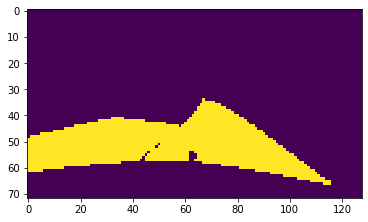

In [77]:
import matplotlib.pyplot as plt

plt.imshow(actual)

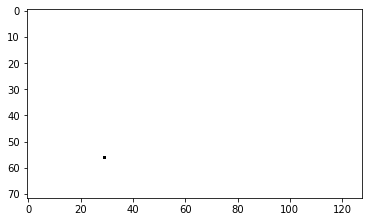

In [78]:
plt.imshow(out, cmap="Greys")

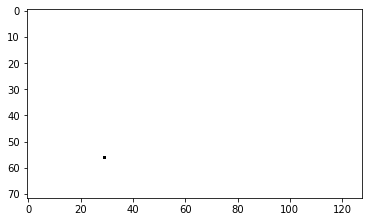

In [79]:
plt.imshow(final, cmap="Greys")

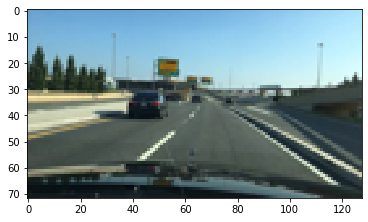

In [80]:
plt.imshow(np.reshape(valX[imNum].numpy(), (ySize,xSize,3)), cmap="Greys")

In [ ]:
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, Softmax, LogSoftmax, Sigmoid, ReLU, NLLLoss, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout2d, Flatten
from torch.optim import Adam, SGD, RMSprop
import torch.nn as nn

class CNN(Module):
    def __init__(self):
        super(CNN,self).__init__() #base class for all neural network modules
        
# #         out_chan_1 = 64
# #         out_chan_2 = 128
# #         out_chan_3 = 256
# #         out_chan_4 = 512
# #         out_chan_5 = 512
        
        out_chan_1 = 3
        out_chan_2 = 5
#         out_chan_1 = 2
#         out_chan_2 = 2
#         out_chan_3 = 4
#         out_chan_4 = 8
#         out_chan_5 = 8
        
# #         out_fc_6 = 4096
# #         out_fc_7 = 4096

#         out_fc_6 = 32
#         out_fc_7 = 32
        
#         n_class = 2
        
#         #k_s_1 = 3
#         #k_s_2 = 3
        k_s = 3
        
#         #k_s_1_mp = 2 #mp = max pool
#         #k_s_2_mp = 2
        k_s_mp = 2
        
#         num_neurons_1 = 10
        
#         output_size = 1 #9216 #depending on num of pixels
        
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
            BatchNorm2d(out_chan_1), #just specify the num of output channels
            ReLU(inplace=True),
            MaxPool2d(kernel_size=k_s_1_mp, stride=2),
      
            # Defining another 2D convolution layer
            Conv2d(out_chan_1, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
            BatchNorm2d(out_chan_2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=k_s_2_mp, stride=2)
        )
        
#         self.cnn_layer1 = Sequential(
#             # Defining a 2D convolution layer
#             Conv2d(1, out_chan_1, kernel_size=k_s, padding=100), 
#             BatchNorm2d(out_chan_1), #just specify the num of output channels
#             ReLU(inplace=True),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s, padding=1), 
#             BatchNorm2d(out_chan_1), #just specify the num of output channels
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=k_s_mp, stride=2, ceil_mode=True)
#         )
        
#         self.cnn_layer2 = Sequential(
#             # Defining another 2D convolution layer
#             Conv2d(out_chan_1, out_chan_2, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_2),
#             ReLU(inplace=True),
#             Conv2d(out_chan_2, out_chan_2, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_2),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=k_s_mp, stride=2, ceil_mode=True)
#         )
        
#         self.cnn_layer3 = Sequential(
#             # Defining another 2D convolution layer
#             Conv2d(out_chan_2, out_chan_3, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_3),
#             ReLU(inplace=True),
#             Conv2d(out_chan_3, out_chan_3, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_3),
#             ReLU(inplace=True),
#             Conv2d(out_chan_3, out_chan_3, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_3),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=k_s_mp, stride=2, ceil_mode=True)
#         )
        
#         self.cnn_layer4 = Sequential(
#             # Defining another 2D convolution layer
#             Conv2d(out_chan_3, out_chan_4, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_4),
#             ReLU(inplace=True),
#             Conv2d(out_chan_4, out_chan_4, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_4),
#             ReLU(inplace=True),
#             Conv2d(out_chan_4, out_chan_4, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_4),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=k_s_mp, stride=2, ceil_mode=True)
#         )
        
#         self.cnn_layer5 = Sequential(
#             # Defining another 2D convolution layer
#             Conv2d(out_chan_4, out_chan_5, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_5),
#             ReLU(inplace=True),
#             Conv2d(out_chan_5, out_chan_5, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_5),
#             ReLU(inplace=True),
#             Conv2d(out_chan_5, out_chan_5, kernel_size=k_s, padding=1),
#             BatchNorm2d(out_chan_5),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=k_s_mp, stride=2, ceil_mode=True)
#         )
        
#         self.cnn_fc6 = Sequential(
#             Conv2d(out_chan_5, out_fc_6, kernel_size=7),
#             BatchNorm2d(out_fc_6),
#             ReLU(inplace=True),
#             Dropout2d()
#         )
        
#         self.cnn_fc7 = Sequential(
#             Conv2d(out_fc_6, out_fc_7, kernel_size=1),
#             BatchNorm2d(out_fc_7),
#             ReLU(inplace=True),
#             Dropout2d()
#         )
        
#         self.score_fr = nn.Conv2d(out_fc_6, output_size, 1)
#         self.score_pool3 = nn.Conv2d(out_chan_3, output_size, 1)
#         self.score_pool4 = nn.Conv2d(out_chan_5, output_size, 1)

#         self.upscore2 = nn.ConvTranspose2d(
#             output_size, output_size, 4, stride=2, bias=False)
#         self.upscore8 = nn.ConvTranspose2d(
#             output_size, output_size, 16, stride=8, bias=False)
#         self.upscore_pool4 = nn.ConvTranspose2d(
#             output_size, output_size, 4, stride=2, bias=False)
        
#         self.sigmoid = Sequential(
#             Sigmoid()
#         )
        
        
# #         self.linear_layers = Sequential(
# #             Linear(out_chan_2 * 31 * 17, num_neurons_1),
# #             Softmax(dim=1),
# #             #ReLU(inplace=True),
# #             Linear(num_neurons_1,output_size),
# #             Sigmoid() # map from 0 to 1
# #             #LogSoftmax(dim=1)
# #             #Softmax(dim=1)
# #             #Sign()
# #             #ReLU(inplace=True)
            
# #         )
        
#     # Defining the forward pass    
#     def forward(self, x):
#         h = self.cnn_layer1(x)
#         h = self.cnn_layer2(h)
        
#         h = self.cnn_layer3(h)
#         pool3 = h
        
#         h = self.cnn_layer4(h)
#         pool4 = h
        
#         h = self.cnn_layer5(h)
        
#         h = self.cnn_fc6(h)
#         h = self.cnn_fc7(h)
        
#         h = self.score_fr(h)
#         h = self.upscore2(h)
#         upscore2 = h  # 1/16

#         h = self.score_pool4(pool4 * 0.01)  # XXX: scaling to train at once
#         h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
#         score_pool4c = h  # 1/16

#         h = upscore2 + score_pool4c  # 1/16
#         h = self.upscore_pool4(h)
#         upscore_pool4 = h  # 1/8

#         h = self.score_pool3(pool3 * 0.0001)  # XXX: scaling to train at once
#         h = h[:, :,
#               9:9 + upscore_pool4.size()[2],
#               9:9 + upscore_pool4.size()[3]]
#         score_pool3c = h  # 1/8

#         h = upscore_pool4 + score_pool3c  # 1/8

#         print(h.shape)
#         h = self.upscore8(h)
#         h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()
        
#         h = self.sigmoid(h)

#         return h
        
    
# #         x = self.cnn_layers(x)
# #         print(x.size())
# #         #x=x.long()
# #         x = x.view(x.size(0), -1)
# #         x = self.linear_layers(x)
# #         #x = x.float()
# #         return x
    

# # defining the model
# model = CNN()
# # defining the optimizer
# # optimizer = SGD(model.parameters(), lr=0.05, momentum=0.5, weight_decay=0.0005)
# # optimizer = RMSprop(model.parameters(), lr=0.01, weight_decay=1e-8, momentum=0.9)
# optimizer = Adam(model.parameters(), lr=0.05)

# # defining the loss function
# #criterion = MSELoss()
# #criterion = CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
# #criterion = nn.BCELoss()


# #checking if GPU is available
# # if torch.cuda.is_available():
# #    model = model.cuda()
# #    criterion = criterion.cuda()
    
# # print(model)

# # trainX = trainX[:2].cuda()

# # output = model(Variable(trainX))
# # output



# def train(epoch, train_x, train_y, val_x, val_y):
#     model.train()
#     tr_loss = 0
#     # getting the training set
#     x_train, y_train = Variable(train_x), Variable(train_y)
#     # getting the validation set
#     x_val, y_val = Variable(val_x), Variable(val_y)
#     # converting the data into GPU format
# #     if torch.cuda.is_available():
# #         x_train = x_train.cuda()
# #         y_train = y_train.cuda()
# #         x_val = x_val.cuda()
# #         y_val = y_val.cuda()

#     # clearing the Gradients of the model parameters
#     optimizer.zero_grad()
    
#     # prediction for training and validation set
#     output_train = model(x_train)
#     output_val = model(x_val)

#     # computing the training and validation loss
#     print(output_train.shape)
#     print(y_train.shape)
#     loss_train = criterion(output_train, y_train)
#     loss_val = criterion(output_val, y_val)
#     train_losses.append(loss_train)
#     val_losses.append(loss_val)

#     # computing the updated weights of all the model parameters
#     loss_train.backward()
#     optimizer.step()
#     tr_loss = loss_train.item()
#     if epoch%2 == 0:
#         # printing the validation loss
#         print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    
#     del loss_train
#     del loss_val
#     del output_train
#     del output_val
#     #torch.cuda.empty_cache()